In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("./datasets/aggregated_county_means_data.csv").drop(["Unnamed: 0", "Rank"], axis = 1)
dc = pd.read_csv("./datasets/dc_final_health_and_income.csv").drop("Unnamed: 0", axis = 1)

%matplotlib inline

In [263]:
df.shape, dc.shape # will need to drop some columns from dc

((325, 29), (1, 37))

In [264]:
dc = dc[list(df.columns)] # filtering for only the columns in df

In [265]:
df = pd.concat([df,dc], axis = 0)

In [266]:
df.head()

,unique_county,COPD,CHOLSCREEN,KIDNEY,BINGE,CHECKUP,PHLTH,OBESITY,ARTHRITIS,CASTHMA,...,MHLTH,CHD,County-equivalent,State,Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds,fips
0,AdaIdaho,4.896226,72.816981,2.245283,16.239623,61.050943,10.307547,26.564151,23.271698,9.081132,...,10.569811,4.809434,Ada,Idaho,27452.0,55210.0,67641.0,"401,673","151,600",16001.0
1,AdamsColorado,5.085484,71.064516,2.282258,17.606452,56.701613,11.450000,26.082258,21.112903,9.396774,...,11.770968,4.567742,Adams,Colorado,24195.0,56270.0,64611.0,"452,030","152,803",8001.0
2,AlachuaFlorida,5.970270,65.648649,2.332432,17.435135,68.908108,11.313514,24.748649,17.683784,9.205405,...,14.359459,4.759459,Alachua,Florida,24857.0,42149.0,62139.0,"249,848","96,043",12001.0
3,AlamedaCalifornia,4.260065,75.583117,2.385065,15.819156,64.941558,10.417857,20.409416,18.578247,8.878247,...,10.723052,4.494481,Alameda,California,35763.0,72112.0,88618.0,"1,535,248","545,071",6001.0
4,AlbanyNew York,6.388462,70.923077,2.638462,17.215385,72.492308,13.015385,29.303846,21.726923,10.876923,...,14.015385,5.419231,Albany,New York,32328.0,59394.0,81846.0,"305,279","122,700",36001.0


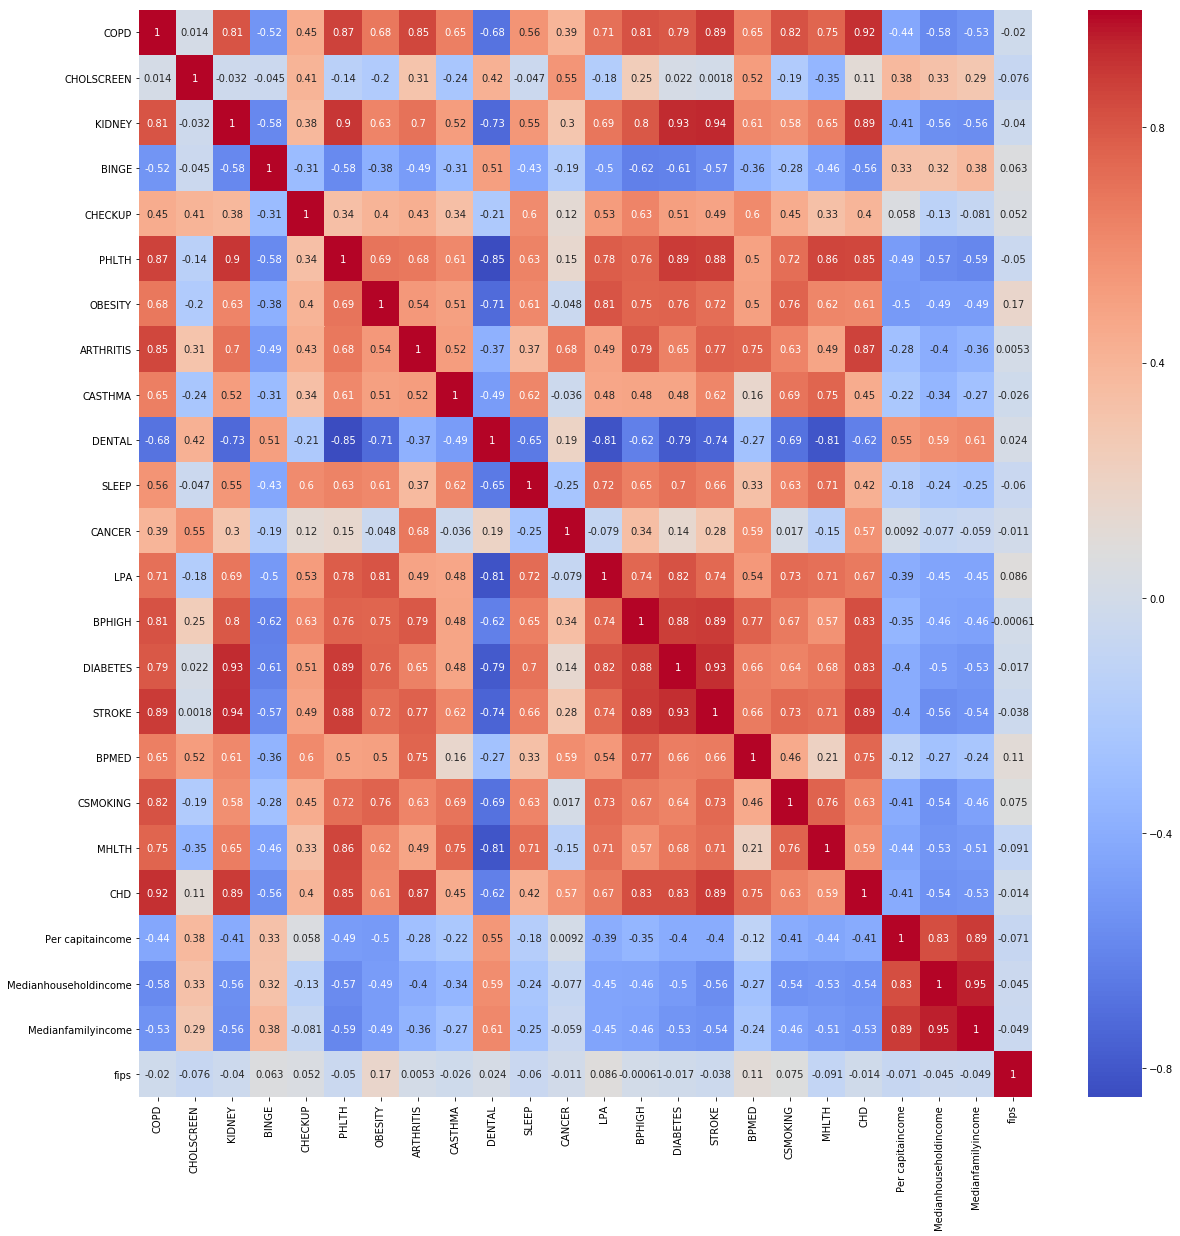

In [240]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df.corr(), annot = True, ax= ax, cmap="coolwarm")
### looking at correlation between variables and per capita income

In [241]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LassoCV

In [94]:
df.columns

Index(['unique_county', 'COPD', 'CHOLSCREEN', 'KIDNEY', 'BINGE', 'CHECKUP',
       'PHLTH', 'OBESITY', 'ARTHRITIS', 'CASTHMA', 'DENTAL', 'SLEEP', 'CANCER',
       'LPA', 'BPHIGH', 'DIABETES', 'STROKE', 'BPMED', 'CSMOKING', 'MHLTH',
       'CHD', 'County-equivalent', 'State', 'Per capitaincome',
       'Medianhouseholdincome', 'Medianfamilyincome', 'Population',
       'Number ofhouseholds', 'fips'],
      dtype='object')

In [198]:
X = df[['COPD', 'CHOLSCREEN', 'KIDNEY', 'BINGE', 'CHECKUP',
       'PHLTH', 'OBESITY', 'ARTHRITIS', 'CASTHMA', 'DENTAL', 'SLEEP', 'CANCER',
       'LPA', 'BPHIGH', 'DIABETES', 'STROKE', 'BPMED', 'CSMOKING', 'MHLTH',
       'CHD']] ## features for modeling
y = df['Per capitaincome'] ## target for modeling

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X,y) #train test split

In [200]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test) # scale the features with scaler fit on training data

## Gradient Boost

In [245]:
gb = GradientBoostingRegressor() ## I originally used gridsearch to optimize, but got the best results
## with the base settings.  XGB gave me the best score, so I tested it on the DC row alone.  

In [246]:
gb.fit(X_train_scaled, y_train)
preds = gb.predict(X_test_scaled)
mean_squared_error(y_test,preds) ** .5

3338.3266218748354

In [229]:
from sklearn.feature_selection import SelectKBest

## XG Boost

In [242]:
xgb = XGBRegressor()

In [331]:
model = xgb.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)
mean_squared_error(y_test, preds) ** .5

3260.358029358543

In [332]:
X_train.columns

Index(['COPD', 'CHOLSCREEN', 'KIDNEY', 'BINGE', 'CHECKUP', 'PHLTH', 'OBESITY',
       'ARTHRITIS', 'CASTHMA', 'DENTAL', 'SLEEP', 'CANCER', 'LPA', 'BPHIGH',
       'DIABETES', 'STROKE', 'BPMED', 'CSMOKING', 'MHLTH', 'CHD'],
      dtype='object')

In [335]:
pd.DataFrame({"features":X_train.columns, "importance": model.feature_importances_}).sort_values("importance", ascending = False)
### this tells us how frequently a feature was chosen to split on at a node
### ... i.e. which features tended to offer the most information gain

,features,importance
1,CHOLSCREEN,0.139159
4,CHECKUP,0.093851
0,COPD,0.092233
8,CASTHMA,0.085761
3,BINGE,0.072816
10,SLEEP,0.067961
18,MHLTH,0.066343
6,OBESITY,0.042071
11,CANCER,0.042071
16,BPMED,0.040453


## Just on DC, going to play with inputs

In [270]:
dc_row = df[df['State'] == "DC"] # looking just at dc data

In [326]:
df.mean() ## mean values for each health metric

COPD                         6.436509
CHOLSCREEN                  72.256933
KIDNEY                       2.682263
BINGE                       16.679401
CHECKUP                     68.508989
PHLTH                       12.834389
OBESITY                     30.998319
ARTHRITIS                   23.098355
CASTHMA                      9.594769
DENTAL                      60.696671
SLEEP                       36.037118
CANCER                       5.798245
LPA                         27.275793
BPHIGH                      31.041000
DIABETES                    10.268362
STROKE                       3.139264
BPMED                       72.909349
CSMOKING                    19.355300
MHLTH                       12.963110
CHD                          5.794042
Per capitaincome         27874.610429
Medianhouseholdincome    54019.116564
Medianfamilyincome       66532.122699
fips                     29562.460123
dtype: float64

In [329]:
dc_row - df.mean() # comparing DC to means to see areas to focus health initiatives
## Ones that stand out where DC is higher than avg include Binge Drinking proportion, Smoking, and Sleep

,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,CASTHMA,CHD,CHECKUP,CHOLSCREEN,COPD,CSMOKING,County-equivalent,DENTAL,DIABETES,KIDNEY,LPA,MHLTH,Medianfamilyincome,Medianhouseholdincome,Number ofhouseholds,OBESITY,PHLTH,Per capitaincome,Population,SLEEP,STROKE,State,fips,unique_county
0,-3.239928,4.57734,-0.886505,0.498516,-0.648245,0.77658,-1.422694,6.203932,5.246999,-1.148868,0.172228,NaN,6.380295,-0.681283,0.041894,-5.800512,-1.182211,13132.877301,11810.883436,NaN,-4.635959,-2.10349,17415.389571,NaN,0.171309,0.250624,NaN,-18062.460123,NaN


In [328]:
pd.set_option("display.max_columns", 500)

## Linear Regression

In [308]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest

In [ ]:
### originally used select K best, but model performed best using all features

In [337]:
lr = LinearRegression()
model = lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
mean_squared_error(y_test, preds) ** .5

3874.313864596304

In [338]:
np.std(model.coef_), np.mean(model.coef_) # used these values to create a standardized importance for the features below

(1758.2322463959933, 110.10996525425824)

In [295]:
coefs = pd.DataFrame({"features":X_train.columns, "coef": model.coef_})

In [296]:
coefs["importance"] = [(x-110.101)/1758.232 for x in coefs.coef]

In [325]:
coefs.sort_values("importance", ascending=False).set_index("features", drop = True) # dataframe of feature importance

,coef,importance
features,,
DIABETES,2639.271953,1.438474
CHOLSCREEN,2267.396690,1.226969
CHD,2102.693649,1.133293
CASTHMA,1844.430869,0.986406
LPA,1535.690434,0.810808
STROKE,1379.008511,0.721695
SLEEP,1212.529898,0.627010
CANCER,630.262853,0.295844
BINGE,516.053646,0.230887


## Random Forest

In [174]:
rf = RandomForestRegressor()
params = {"n_estimators":[7,10,12,15],
         "max_depth":[None,7,5,3],
         "min_samples_split":[2,3,4],
         "min_samples_leaf":[1,2],
         "n_jobs":[4]}

In [175]:
gs = GridSearchCV(estimator=rf, param_grid=params)

In [176]:
gs.fit(X_train_scaled,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [7, 10, 12, 15], 'max_depth': [None, 7, 5, 3], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2], 'n_jobs': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [177]:
gs.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 10,
 'n_jobs': 4}

In [178]:
preds = gs.predict(X_test_scaled)

In [179]:
mean_squared_error(y_test, preds) ** .5

4726.791407785618

## Lasso

In [187]:
las = LassoCV(n_jobs=4)
las.fit(X_train_scaled, y_train)
preds = las.predict(X_test_scaled)
mean_squared_error(y_test, preds)** .5

5084.98827600365